## House market analysis and calculating investments payback 


## Project Description

This notebook is part of my bachelor thesis at the Czech University of Life Sciences (major Informatics).

In this work I implement four custom parsers that collect data about apartments for **rent** and **sale** from the Czech real-estate portals **Bezrealitky** and **Sreality**.

I train several machine learning models on apartments listed **for rent** and select the best-performing model. I then use this model to predict **rental prices** for apartments that are listed **for sale**.

Based on these predicted rents, I:

- estimate the expected **annual profit** from renting out a given apartment, and  
- calculate **how many years** it would take for the apartment to pay for itself (simple payback period).

> Note: The rental prices are collected **without utility costs**. Utilities are paid separately by the tenant and are therefore excluded from the analysis.

---

## Modeling Pipeline

The models are trained inside a custom pipeline composed of the following classes:

- `Data_splitter` – splits the dataset into three parts: `train`, `test`, and `unknown`.
- `Encoder` – applies different encoding strategies to categorical features depending on the stage of the pipeline.
- `FurnishingImputer` – imputes missing values in the `furnishing` feature using a supervised model.

---

### Why I use an `unknown` split in `Data_splitter`

In my dataset, approximately **25%** of the values in the `furnishing` column are missing.

To handle this, I:

1. Separate all rows with missing `furnishing` into the `unknown` subset.
2. Train a **custom imputer** (`FurnishingImputer`) using a `RandomForestClassifier` on rows where `furnishing` is known.
3. Use this classifier to **predict** and fill in the missing `furnishing` values in the `unknown` subset (and, if needed, in the full dataset).

I trained models **with** and **without** furnishing imputation. The final rental price prediction metrics changed only slightly. However, I decided to keep the imputer because:

- it provides the model with **additional information** , and  
- it makes the dataset more complete and informative for downstream model learning.

---

### `Encoder`

For each stage of the pipeline, I use different encoding strategies for categorical variables:

- `disposition` – encoded as an **ordinal** feature (e.g. smaller apartments < larger apartments).
- `furnishing` – encoded only in the **final rental price prediction** stage (after imputation(in Imputation target col = **furnishing**)).
- `district`:
  - in `FurnishingImputer` it is encoded using **count encoding** to reduce data leakage;
  - in the final rental price model it is encoded using **target encoding** (district → average target price).

This design allows me to:
- avoid target leakage when training the imputer,
- and still use a more powerful target encoding in the final price model.

---

### `FurnishingImputer`

The `FurnishingImputer` class is responsible for imputing missing values in the `furnishing` column.

- It trains a `RandomForestClassifier` on rows where `furnishing` is known, using other apartment features as predictors.
- It then predicts `furnishing` for rows where this value is missing.
- Optionally, it can add a flag indicating which values were imputed and which were originally present.

This approach treats furnishing imputation as a **supervised learning problem**, instead of using simple strategies like dropping rows or filling with a constant category.

# 1 Import Libraries

In [2]:
# Standard library imports
import json
import re
from datetime import datetime

# Third-party imports - Data manipulation
import numpy as np
import pandas as pd

# Third-party imports - Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Third-party imports - API requests
import requests
from requests.exceptions import RequestException

# Third-party imports - Machine Learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from category_encoders import TargetEncoder, CountEncoder
from sklearn.metrics import classification_report, accuracy_score 

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# 2 Data Loading


## 2.1 Loading rent data

In [ ]:
def parsing_bezreality_data():
    url = 'https://api.bezrealitky.cz/graphql/'

    headers = {
        "accept": "*/*",
        "content-type": "application/json",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    }

    all_data = []
    limit = 15
    offset = 0

    while True:
        data = {
    "query": """
    query AdvertList($locale: Locale!, $estateType: [EstateType], $offerType: [OfferType], $regionOsmIds: [ID], $limit: Int, $offset: Int, $order: ResultOrder , $disposition: [Disposition]) {
        listAdverts(
            locale: $locale,
            estateType: $estateType,
            offerType: $offerType,
            regionOsmIds: $regionOsmIds,
            limit: $limit,
            offset: $offset,
            order: $order, 
            disposition: $disposition,
           
            
        ) {
            list {
                id
                price
                currency
                estateType
                offerType
                address(locale: $locale)
                tags(locale: $locale)
                imageAltText(locale: $locale)
                dataJson
                surface
                garage
                disposition
                gps {
                    lat
                    lng
                }
           }    
            totalCount
        }
    }
    """,
    "variables": {
        "locale": "CS",
        "estateType": ["BYT"],
        "offerType": ["PRONAJEM"],
        "regionOsmIds": ["R435514"],
        "limit": limit,
        "offset": offset,
        "order": "TIMEORDER_DESC"
    }

        }

        try:
            response = requests.post(url, headers=headers, json=data)
            response.raise_for_status()
            response_json = response.json()

            adverts = response_json['data']['listAdverts']['list']
            if not adverts:
                break

            for ad in adverts:
                tags = ad.get("tags", [])
                if 'Vybaveno' in tags: # Furnished
                    furnishing = 'furnished'
                elif 'Částečně vybaveno' in tags: # Partially furnished
                    furnishing = 'partially_furnished'
                elif 'Nevybaveno' in tags: # Unfurnished
                    furnishing = 'unfurnished'
                else:
                    furnishing = 'unknown'
                mhd = any('MHD' in tag for tag in tags)
                balcony=any('Balkón' in tag for tag in tags)
                loggia=any('Lodžie' in tag for tag in tags)
                gps = ad.get("gps", {})
                latitude = gps.get("lat")
                longitude = gps.get("lng")
                all_data.append({
                    "id": ad.get("id"),
                    "price": ad.get("price"),
                    "currency": ad.get("currency"),
                    "address": ad.get("address"),
                    "estateType": ad.get("estateType"),
                    "offerType": ad.get("offerType"),
                    "disposition": ad.get("disposition"),
                    "surface": ad.get("surface"),
                    "garage": ad.get("garage"),
                    "tags": tags,
                    "furnishing": furnishing,
                    "mhd": mhd,
                    "balcony": balcony,
                    "loggia": loggia,   
                    "latitude": latitude,
                    "longitude": longitude,
                    "imageAltText": ad.get("imageAltText"),
                })

            offset += limit

        except RequestException as e:
            print(f"Error: {e}")
            break

    df = pd.DataFrame(all_data)


    print("Total records received:", len(df))
    return df

In [4]:
def parse_sreality_data(pages=5):
    url = "https://www.sreality.cz/api/cs/v2/estates"
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/json"
    }

    all_data = []
    per_page = 100  
    for page in range(pages):
        params = {
            "category_main_cb": 1,      
            "category_type_cb": 2,     
            "per_page": per_page,
            "region_entity_id": 10,
            "page": page
        }

        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()  
            data = response.json()

            estates = data['_embedded']['estates']

            for estate in estates:
                labels_all = estate.get("labelsAll", [])
                tech_labels = labels_all[0] if len(labels_all) > 0 else []
                infra_labels = labels_all[1] if len(labels_all) > 1 else []

               
                if 'furnished' in tech_labels:
                    furnishing = 'furnished'
                elif 'partly_furnished' in tech_labels:
                    furnishing = 'partly_furnished'
                elif 'not_furnished' in tech_labels:
                    furnishing = 'not_furnished'
                else:
                    furnishing = None

                mhd_tag={'bus_public_transport', 'tram', 'metro' , 'train'}
                mhd=any(tag in infra_labels for tag in mhd_tag)
                garage=any('garage' in tech_labels for infa in tech_labels)
                loggia=any('loggia' in tech_labels for infa in tech_labels)
                balcony=any('balcony' in tech_labels for infa in tech_labels)
                gps=estate.get("gps" , {})
                latitude=gps.get("lat") 
                longitude= gps.get("lon") 
                all_data.append({
                    "locality": estate.get("locality"),
                    "price": estate.get("price"),
                    "name": estate.get("name"),
                    "city_raw": estate.get("seo", {}).get("locality"),
                    "labels_all": labels_all,
                    "furnishing": furnishing,
                    "mhd": mhd,
                    "garage": garage,
                    "loggia": loggia,
                    "balcony": balcony,
                    "gps": gps,
                    "latitude": latitude,
                    "longitude": longitude,
                })

        except requests.exceptions.RequestException as e:
            print(f"Error while fetching page {page + 1}: {e}")
            break

    df = pd.DataFrame(all_data)
    print("✅ Total listings fetched:", len(df))
    return df


In [5]:
df_bezreality = parsing_bezreality_data()

Total records received: 1037


In [6]:
df_sreality = parse_sreality_data(100)

✅ Total listings fetched: 10000


## 2.2 Loading sell data

In [7]:
def parsing_bezrealitky_sell_data():
    url = 'https://api.bezrealitky.cz/graphql/'

    headers = {
        "accept": "*/*",
        "content-type": "application/json",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    }

    all_data = []
    limit = 15
    offset = 0

    while True:
        data = {
    "query": """
    query AdvertList($locale: Locale!, $estateType: [EstateType], $offerType: [OfferType], $regionOsmIds: [ID], $limit: Int, $offset: Int, $order: ResultOrder , $disposition: [Disposition]) {
        listAdverts(
            locale: $locale,
            estateType: $estateType,
            offerType: $offerType,
            regionOsmIds: $regionOsmIds,
            limit: $limit,
            offset: $offset,
            order: $order, 
            disposition: $disposition,
           
            
        ) {
            list {
                id
                price
                currency
                estateType
                offerType
                address(locale: $locale)
                tags(locale: $locale)
                imageAltText(locale: $locale)
                dataJson
                surface
                garage
                disposition
                gps {
                    lat
                    lng
                }
           }    
            totalCount
        }
    }
    """,
    "variables": {
        "locale": "CS",
        "estateType": ["BYT"],
        "offerType": ["PRODEJ"],
        "regionOsmIds": ["R435514"],
        "limit": limit,
        "offset": offset,
        "order": "TIMEORDER_DESC"
    }

        }

        try:
            response = requests.post(url, headers=headers, json=data)
            response.raise_for_status()
            response_json = response.json()

            adverts = response_json['data']['listAdverts']['list']
            if not adverts:
                break

            for ad in adverts:
                tags = ad.get("tags", [])
                if 'Vybaveno' in tags:
                    furnishing = 'furnished'
                elif 'Částečně vybaveno' in tags:
                    furnishing = 'partially_furnished'
                elif 'Nevybaveno' in tags:
                    furnishing = 'unfurnished'
                else:
                    furnishing = 'unknown'
                mhd = any('MHD' in tag for tag in tags)
                balcony=any('Balkón' in tag for tag in tags)
                loggia=any('Lodžie' in tag for tag in tags)
                gps = ad.get("gps", {})
                latitude = gps.get("lat")
                longitude = gps.get("lng")
                all_data.append({
                    "id": ad.get("id"),
                    "price": ad.get("price"),
                    "currency": ad.get("currency"),
                    "address": ad.get("address"),
                    "estateType": ad.get("estateType"),
                    "offerType": ad.get("offerType"),
                    "disposition": ad.get("disposition"),
                    "surface": ad.get("surface"),
                    "garage": ad.get("garage"),
                    "tags": tags,
                    "furnishing": furnishing,
                    "mhd": mhd,
                    "balcony": balcony,
                    "loggia": loggia,   
                    "latitude": latitude,
                    "longitude": longitude,
                    "imageAltText": ad.get("imageAltText"),
                })

            offset += limit

        except RequestException as e:
            print(f"Error: {e}")
            break

    df = pd.DataFrame(all_data)


    print("Total records received:", len(df))
    return df

In [8]:
def parse_sreality_sell_data(pages=5):
    url = "https://www.sreality.cz/api/cs/v2/estates"
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/json"
    }

    all_data = []
    per_page = 100  
    for page in range(pages):
        params = {
            "category_main_cb": 1,      
            "category_type_cb": 1,     
            "per_page": per_page,
            "region_entity_id": 10,
            "page": page
        }

        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()  
            data = response.json()

            estates = data['_embedded']['estates']

            for estate in estates:
                labels_all = estate.get("labelsAll", [])
                tech_labels = labels_all[0] if len(labels_all) > 0 else []
                infra_labels = labels_all[1] if len(labels_all) > 1 else []

               
                if 'furnished' in tech_labels:
                    furnishing = 'furnished'
                elif 'partly_furnished' in tech_labels:
                    furnishing = 'partly_furnished'
                elif 'not_furnished' in tech_labels:
                    furnishing = 'not_furnished'
                else:
                    furnishing = None

                mhd_tag={'bus_public_transport', 'tram', 'metro' , 'train'}
                mhd=any(tag in infra_labels for tag in mhd_tag)
                garage=any('garage' in tech_labels for infa in tech_labels)
                loggia=any('loggia' in tech_labels for infa in tech_labels)
                balcony=any('balcony' in tech_labels for infa in tech_labels)
                gps=estate.get("gps" , {})
                latitude=gps.get("lat") 
                longitude= gps.get("lon") 
                all_data.append({
                    "locality": estate.get("locality"),
                    "price": estate.get("price"),
                    "name": estate.get("name"),
                    "city_raw": estate.get("seo", {}).get("locality"),
                    "labels_all": labels_all,
                    "furnishing": furnishing,
                    "mhd": mhd,
                    "garage": garage,
                    "loggia": loggia,
                    "balcony": balcony,
                    "gps": gps,
                    "latitude": latitude,
                    "longitude": longitude,
                })

        except requests.exceptions.RequestException as e:
            print(f"Error while fetching page {page + 1}: {e}")
            break

    df = pd.DataFrame(all_data)
    print("✅ Total listings fetched:", len(df))
    return df


In [9]:
df_bezreality_sell = parsing_bezrealitky_sell_data()

Total records received: 374


In [10]:
df_sreality_sell = parse_sreality_sell_data(50)

✅ Total listings fetched: 5000


# 3 Data Cleaning & Feature Engineering

## 3.2 Creating new features

In [11]:
def extract_district(locality):
    if pd.isna(locality):
        return None
    parts = re.split(r'\s*[-–]\s*', locality)
    if len(parts) > 1:
        return parts[-1].strip()
    return None

In [12]:
df_sreality['district'] = df_sreality['locality'].apply(extract_district)
df_sreality_sell['district'] = df_sreality_sell['locality'].apply(extract_district)

df_sreality['disposition'] = df_sreality['name'].str.extract(r'(\d+\+?kk|\d+\+\d+)')
df_sreality['surface'] = df_sreality['name'].str.extract(r'(\d+)\s?m²').astype(int)    

df_sreality_sell['disposition'] = df_sreality_sell['name'].str.extract(r'(\d+\+?kk|\d+\+\d+)')
df_sreality_sell['surface'] = df_sreality_sell['name'].str.extract(r'(\d+)\s?m²').astype(int)

df_bezreality['district'] = df_bezreality['address'].str.split('-').str[-1].str.strip()
df_bezreality_sell['district'] = df_bezreality_sell['address'].str.split('-').str[-1].str.strip()

df_sreality=df_sreality[df_sreality['city_raw'].str.contains("praha", na=False)]
df_sreality_sell=df_sreality_sell[df_sreality_sell['city_raw'].str.contains("praha", na=False)]

Since our srealitky parser scraped listings from all cities in the Czech Republic, </br>
we will filter them by checking whether the word 'Praha' appears in the 'city_raw' feature </br>

In [13]:
df_sreality=df_sreality[df_sreality['city_raw'].str.contains("praha", na=False)]
df_sreality_sell=df_sreality_sell[df_sreality_sell['city_raw'].str.contains("praha", na=False)]

In [14]:
def normalize_disposition(val):
        mapping = {
            'GARSONIERA': '1+kk',
            'DISP_1_KK': '1+kk',
            'DISP_1_1': '1+1',
            'DISP_2_KK': '2+kk',
            'DISP_2_1': '2+1',
            'DISP_3_KK': '3+kk',
            'DISP_3_1': '3+1',
            'DISP_4_KK': '4+kk',
            'DISP_4_1': '4+1',
            'DISP_5_KK': '5+kk',
            'DISP_5_1': '5+1',
            'DISP_6_KK': '6+kk',
            'DISP_6_1': '6+1',
            'DISP_7_KK': '7+kk',
            'DISP_7_1': '7+1',  
            'OSTATNI': 'other'
        }
        return mapping.get(val, val)
df_bezreality['disposition'] = df_bezreality['disposition'].apply(normalize_disposition)
df_bezreality_sell['disposition'] = df_bezreality_sell['disposition'].apply(normalize_disposition)

In [15]:
combined_rent_df = pd.concat([df_bezreality, df_sreality], ignore_index=True)
combined_sell_df = pd.concat([df_bezreality_sell, df_sreality_sell], ignore_index=True)

In [16]:
combined_rent_df['price_per_m2']=round(combined_rent_df['price']/combined_rent_df['surface'],1)
combined_sell_df['price_per_m2']=round(combined_sell_df['price']/combined_sell_df['surface'],1)

Droping useless columms for training models

In [17]:
cols_to_drop = [
    'id', 'currency', 'estateType', 'offerType', 'tags',
    'imageAltText', 'city_raw', 'gps', 'locality', 'labels_all', 
    'name' , 'address'
]
combined_rent_df = combined_rent_df.drop(columns=cols_to_drop)
combined_sell_df = combined_sell_df.drop(columns=cols_to_drop)

In [18]:
combined_rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         4160 non-null   int64  
 1   disposition   4084 non-null   object 
 2   surface       4160 non-null   int64  
 3   garage        4160 non-null   bool   
 4   furnishing    3313 non-null   object 
 5   mhd           4160 non-null   bool   
 6   balcony       4160 non-null   bool   
 7   loggia        4160 non-null   bool   
 8   latitude      4160 non-null   float64
 9   longitude     4160 non-null   float64
 10  district      4081 non-null   object 
 11  price_per_m2  4160 non-null   float64
dtypes: bool(4), float64(3), int64(2), object(3)
memory usage: 276.4+ KB


In [19]:
combined_sell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         2303 non-null   int64  
 1   disposition   2278 non-null   object 
 2   surface       2303 non-null   int64  
 3   garage        2303 non-null   bool   
 4   furnishing    1398 non-null   object 
 5   mhd           2303 non-null   bool   
 6   balcony       2303 non-null   bool   
 7   loggia        2303 non-null   bool   
 8   latitude      2303 non-null   float64
 9   longitude     2303 non-null   float64
 10  district      2215 non-null   object 
 11  price_per_m2  2303 non-null   float64
dtypes: bool(4), float64(3), int64(2), object(3)
memory usage: 153.1+ KB


In [20]:
dispositions_to_exclude = [
    '5+kk', '5+1',
    '6+kk', '6+1',
    '7+kk', '7+1',
    'UNDEFINED' , 'other'
]
df_rent_filtered = combined_rent_df[~combined_rent_df['disposition'].isin(dispositions_to_exclude)]
df_sell_filtered = combined_sell_df[~combined_sell_df['disposition'].isin(dispositions_to_exclude)]

In [21]:
URL = "https://data.pid.cz/stops/json/stops.json" #Open PID data with all stops(not only metro) , represented as JSON file

def load_prague_metro_stations():
    raw = requests.get(URL, timeout=30).json()

    groups = (pd.json_normalize(raw["stopGroups"])
              .rename(columns={
                  "name": "station_name",
                  "avgLat": "latitude",
                  "avgLon": "longitude"
              }))

    metro = groups[groups["mainTrafficType"].astype(str)
                   .str.contains("metro", case=False, na=False)]

    stations = (metro[["station_name", "latitude", "longitude"]]
                .dropna(subset=["latitude", "longitude"])
                .sort_values("station_name")
                .reset_index(drop=True))

    return stations

stations = load_prague_metro_stations()
print("Total counts:", len(stations))
print(stations.head())

Total counts: 56
  station_name   latitude  longitude
0        Anděl  50.071260  14.403365
1   Bořislavka  50.098570  14.364120
2  Budějovická  50.044940  14.448228
3       Chodov  50.031216  14.491330
4     Dejvická  50.100925  14.393180


In [22]:
def add_nearest_metro_features(df, metro_df):
    # Ensure latitude and longitude columns exist in dataframes
    assert {"latitude", "longitude"}.issubset(df.columns) 
    assert {"latitude", "longitude"}.issubset(metro_df.columns)

    nn = NearestNeighbors(n_neighbors=1, metric="haversine", algorithm="ball_tree")

    metro_coords = np.radians(metro_df[["latitude", "longitude"]]) #pivot points
    apt_coords   = np.radians(df[["latitude", "longitude"]])

    nn.fit(metro_coords) #algortithm builts the tree to indetify in future closest points , without call , algorithm wont know where the points are located

    dist, idx = nn.kneighbors(apt_coords) # searching for nearest metro station for each apartment

    df["distance_to_metro_km"] = (dist.flatten() * 6371).round(1)

    name_col = "station_name" if "station_name" in metro_df.columns else "name"
    df["nearest_metro"] = metro_df.iloc[idx.flatten()][name_col].values

    return df

In [23]:
CBD_LAT, CBD_LON = 50.08815, 14.41585 #Coordinates of Prague city center (Mustek)

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi, dlmb = np.radians(lat2 - lat1), np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlmb/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df_rent_filtered = df_rent_filtered.copy()
df_sell_filtered = df_sell_filtered.copy()
df_rent_filtered["distance_to_​center"] = round(haversine_km(df_rent_filtered["latitude"], df_rent_filtered["longitude"], CBD_LAT, CBD_LON), 1)
df_sell_filtered["distance_to_​center"] = round(haversine_km(df_sell_filtered["latitude"], df_sell_filtered["longitude"], CBD_LAT, CBD_LON), 1)
results = []

# Calculating correlation and linear regression between distance to center and price (grouped by disposition bcs of difference in prices), 
for disp, sub in df_rent_filtered.groupby("disposition"):
    if len(sub) < 20:
        continue

    X = sub["distance_to_​center"].values.reshape(-1, 1)
    y = sub["price"].values
    model = LinearRegression().fit(X, y)

    results.append({
        "disposition": disp,
        "n": len(sub),
        "slope": float(model.coef_[0]),
        "intercept": float(model.intercept_),
        "R2": float(model.score(X, y)),
        "pearson_r": float(np.corrcoef(sub["distance_to_​center"], sub["price_per_m2"])[0, 1])
    })

out = pd.DataFrame(results).sort_values("slope").round(2)
display(out)

,disposition,n,slope,intercept,R2,pearson_r
6,4+1,78,-4898.85,71065.06,0.25,-0.30
7,4+kk,197,-3398.50,70248.53,0.20,-0.36
4,3+1,263,-2895.02,48081.77,0.31,-0.45
5,3+kk,684,-2448.58,50111.57,0.20,-0.36
2,2+1,296,-1307.75,29904.85,0.21,-0.24
3,2+kk,1379,-888.61,29999.20,0.14,-0.26
1,1+kk,691,-527.68,21667.13,0.11,-0.32
0,1+1,144,-506.18,20805.70,0.11,-0.16


In [24]:
df_rent_filtered=add_nearest_metro_features(df_rent_filtered, stations)
df_sell_filtered=add_nearest_metro_features(df_sell_filtered, stations)
#Adding new feature (more features we have to add better for model , in the end we will see how much they help using SHAP) 

In [25]:
df_rent_filtered['furnishing'].value_counts()

furnishing
furnished              1265
partly_furnished        673
not_furnished           590
partially_furnished     319
unknown                 128
Name: count, dtype: int64

In [26]:
df_sell_filtered['furnishing'].value_counts()

furnishing
not_furnished          410
partly_furnished       341
furnished              323
partially_furnished    146
unknown                131
Name: count, dtype: int64

In [27]:
df_rent_filtered['furnishing']=df_rent_filtered['furnishing'].replace({'partially_furnished':'partly_furnished'})
df_rent_filtered['furnishing']=df_rent_filtered['furnishing'].replace({'unknown':np.nan})
df_sell_filtered['furnishing']=df_sell_filtered['furnishing'].replace({'partially_furnished':'partly_furnished'})
df_sell_filtered['furnishing']=df_sell_filtered['furnishing'].replace({'unknown':np.nan})
#Lets make one common type and remove unknown on nan , for future Imputation

# 4 EDA 

## 4.1 Count of Adverts by Disposition

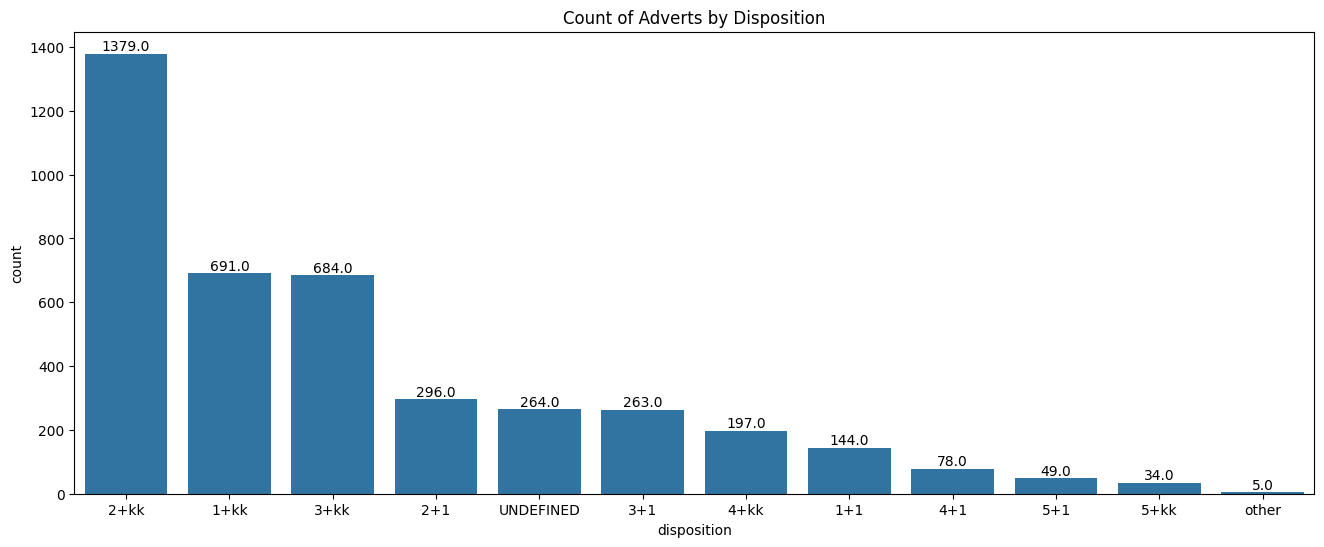

In [28]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(data=combined_rent_df, x='disposition', order=combined_rent_df['disposition'].value_counts().index)
plt.title('Count of Adverts by Disposition')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.show()

<span style="font-size:17px;">
The plot shows that the majority of listings are for apartments with 1–3 rooms.<br>
Listings with 4 or more rooms are rare and can be excluded from further analysis.
</span>

<span style="font-size:17px;">
Aggregating by disposition, rounding mean values, and extracting 'count' into a separate column
</span>

In [29]:
df_agg=df_rent_filtered.groupby('disposition')[['price', 'surface']].aggregate(['mean', 'count', 'min', 'max']).reset_index()
# Round the mean values for better readability
df_agg[('price', 'mean')]=df_agg[('price', 'mean')].round(0)
df_agg['surface', 'mean'] = df_agg[('surface', 'mean')].round(0)
#Drop the count of surface as it is not needed , bcs we already have the count of disposition in price
df_agg = df_agg.drop(columns=[('surface', 'count')])

df_agg = df_agg.sort_values(by=('price', 'count'), ascending=False)
df_agg.head(11)

disposition    price                      surface         
                  mean count    min     max    mean min  max
3        2+kk  25289.0  1379      1   75000    54.0  28  209
1        1+kk  18727.0   691      1   45000    33.0  10  114
5        3+kk  38894.0   684      1  180000    90.0  43  305
2         2+1  24673.0   296      1   59000    63.0  16  120
4         3+1  36256.0   263  10000  100000    91.0  54  173
7        4+kk  56529.0   197  13500  134800   129.0  35  283
0         1+1  18757.0   144  10200   42000    40.0  26   76
6         4+1  58743.0    78   5000  129000   148.0   9  265

## 4.2 Average price by disposition

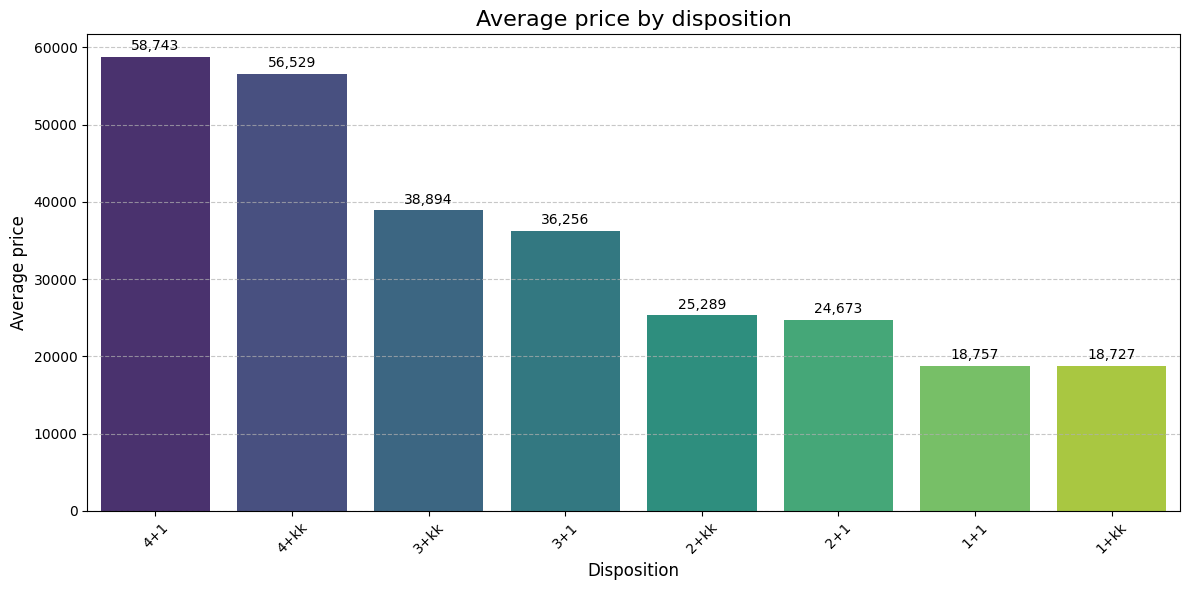

In [30]:
plt.figure(figsize=(12, 6))
df_agg = df_agg.sort_values(by=('price', 'mean'), ascending=False)

ax = sns.barplot(
    data=df_agg,
    x='disposition',
    y=('price', 'mean'),
    palette='viridis'
)

plt.title('Average price by disposition', fontsize=16)
plt.xlabel('Disposition', fontsize=12)
plt.ylabel('Average price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 500,  
        s=f'{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()

<span style="font-size:19px;">
Plot shows how av price changes for every disposition . The more rooms, the more expensive rent 
</span>

## 4.3 Average surface by disposition

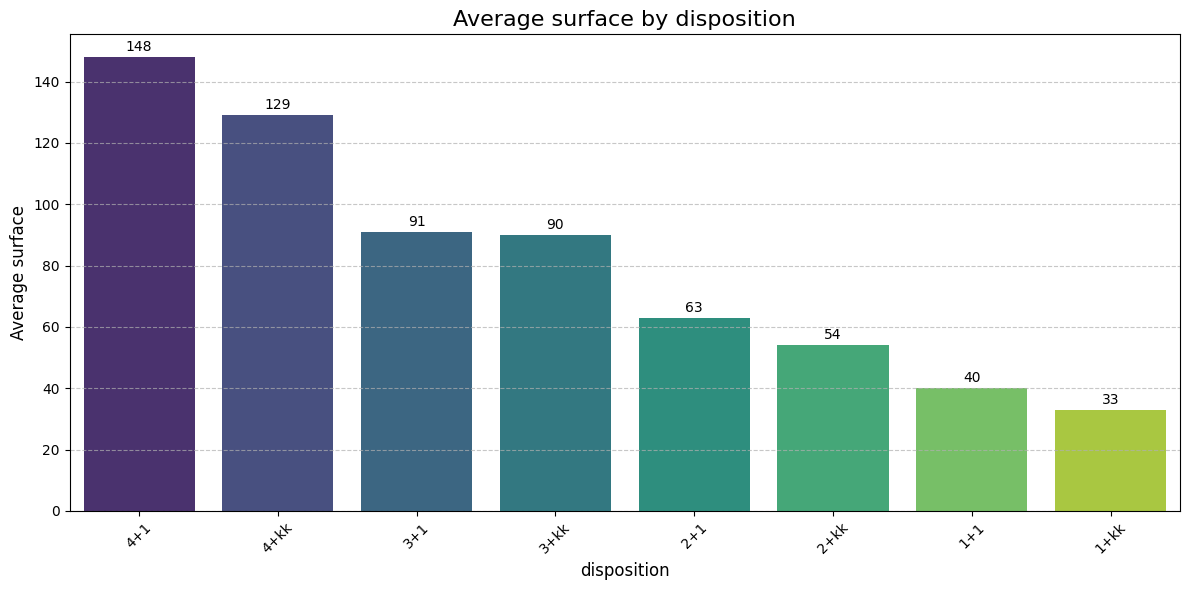

In [31]:
plt.figure(figsize=(12, 6))
df_agg = df_agg.sort_values(by=('surface', 'mean'), ascending=False)

ax = sns.barplot(
    data=df_agg, 
    x='disposition', 
    y=('surface', 'mean'),
    palette='viridis'
)

plt.title('Average surface by disposition', fontsize=16)
plt.xlabel('disposition', fontsize=12)
plt.ylabel('Average surface', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 1,  
        s=f'{height:.0f}',  
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()

<span style="font-size:17px;">
Apartments with dispositions like `1+kk`, `2+1` offer a good balance between price and surface area.<br>
For rental purposes, smaller apartments (1–2 rooms) are generally more cost-effective and easier to rent out quickly.<br>
</span>

## 4.4 Count of Adverts with Garage'

Text(0.5, 1.0, 'Count of Adverts with Garage')

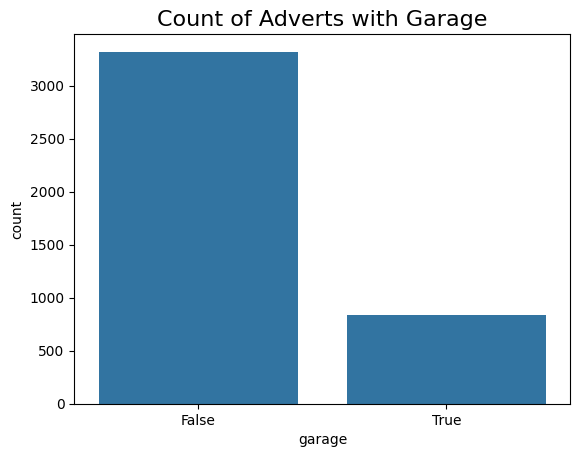

In [32]:
sns.countplot(data= combined_rent_df , x='garage')
plt.title('Count of Adverts with Garage', fontsize=16)

## 4.5 Price Distribution

(0.0, 125000.0)

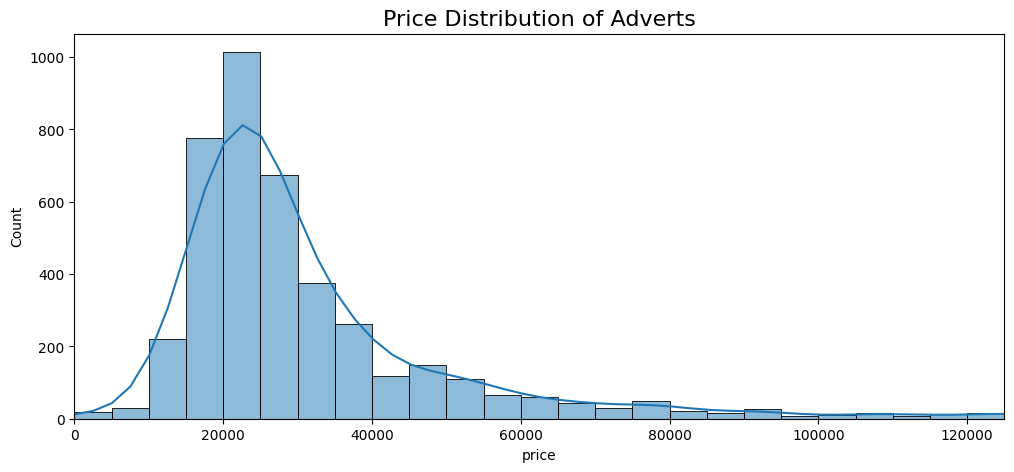

In [33]:
plt.figure(figsize=(12, 5))
sns.histplot(data=combined_rent_df, x='price', bins=100, kde=True)
plt.title('Price Distribution of Adverts', fontsize=16)
plt.xlim(0, 125000)

<span style="font-size:17px;"> 
Mode is around 20–25k; most listings lie roughly in the 15–35k range.
A long right tail extends beyond 80–100k, indicating substantial high-price outliers.
Because of the skew and outliers, the mean will exceed the median and is not a robust “typical” price.

</span>

## 4.6 Surface Distribution

(0.0, 150.0)

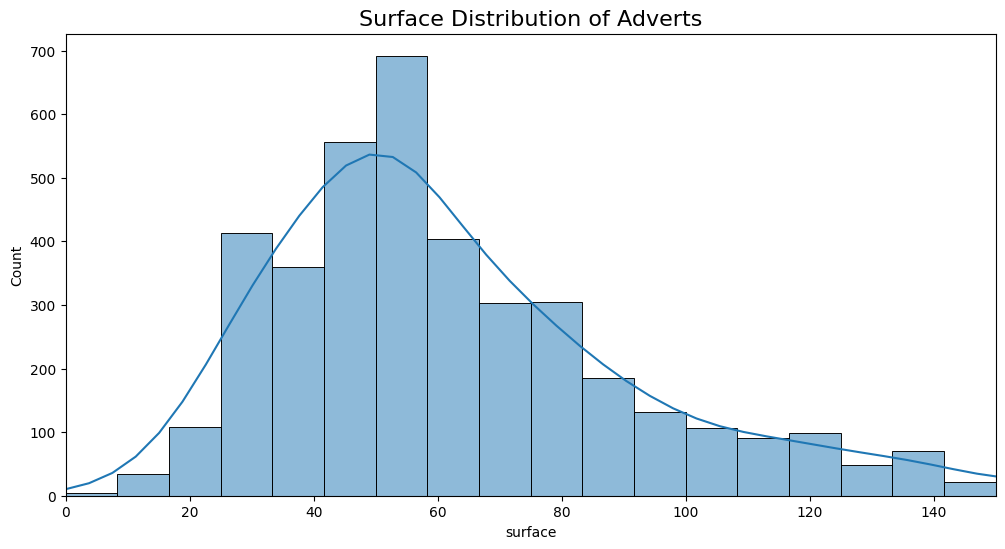

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_rent_df, x='surface', bins=90, kde=True)
plt.title('Surface Distribution of Adverts', fontsize=16)
plt.xlim(0, 150)

<span style="font-size:17px;">
Most apartments have a surface area between 40 and 70 square meters. <br>
The distribution is right-skewed, with fewer large apartments over 100 m², indicating a market focused on compact living spaces. <br>
</span>

In [35]:
top_districts = df_rent_filtered['district'].value_counts().head(10).index
df_top_districts = df_rent_filtered[df_rent_filtered['district'].isin(top_districts)]

In [36]:
agg_numeric = df_top_districts.groupby('district')[['price']].aggregate(['mean', 'count'])
agg_disposition = df_top_districts.pivot_table(index='district', columns='disposition', aggfunc='size', fill_value=0)
# Round the mean values for better readability
agg_numeric[('price', 'mean')] = agg_numeric[('price', 'mean')].round(0)


# Add count  and deleting (price, count) for better readability
agg_numeric['count'] = agg_numeric[('price', 'count')]

agg_numeric= agg_numeric.drop(columns=[('price', 'count')])
agg_numeric = agg_numeric.sort_values(by=('count'), ascending=False)
df_final= pd.concat([agg_numeric, agg_disposition], axis=1)
df_final.head(10)

,"(price, mean)","(count, )",1+1,1+kk,2+1,2+kk,3+1,3+kk,4+1,4+kk
district,,,,,,,,,,
Vinohrady,42050.0,304,12,26,22,85,25,103,5,25
Nové Město,41453.0,247,13,42,24,52,25,48,16,17
Žižkov,26648.0,220,14,47,23,81,7,36,0,9
Smíchov,32448.0,218,9,30,18,92,15,30,5,16
Nusle,25917.0,162,10,44,6,68,4,19,1,7
Holešovice,30493.0,137,10,30,13,54,6,17,0,4
Vršovice,25132.0,127,6,21,22,50,7,15,0,5
Chodov,21906.0,125,3,31,1,67,4,15,3,1
Libeň,25117.0,124,7,25,5,60,5,14,1,7


## 4.7  🔍 Scatter Plot: Surface vs Price

<Axes: xlabel='surface', ylabel='price'>

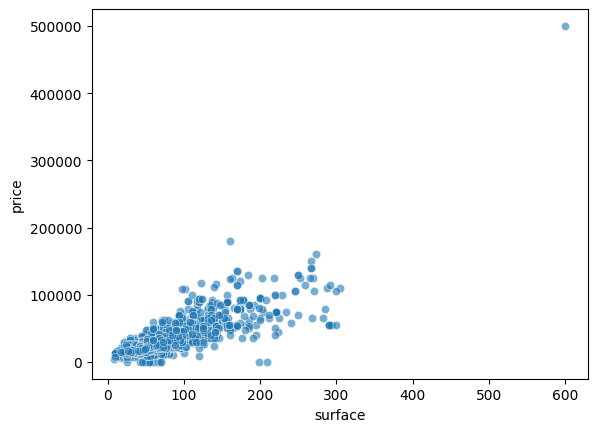

In [38]:
sns.scatterplot(data=df_rent_filtered, x='surface', y='price', alpha=0.6)

## 4.8 Price vs Surface by Disposition

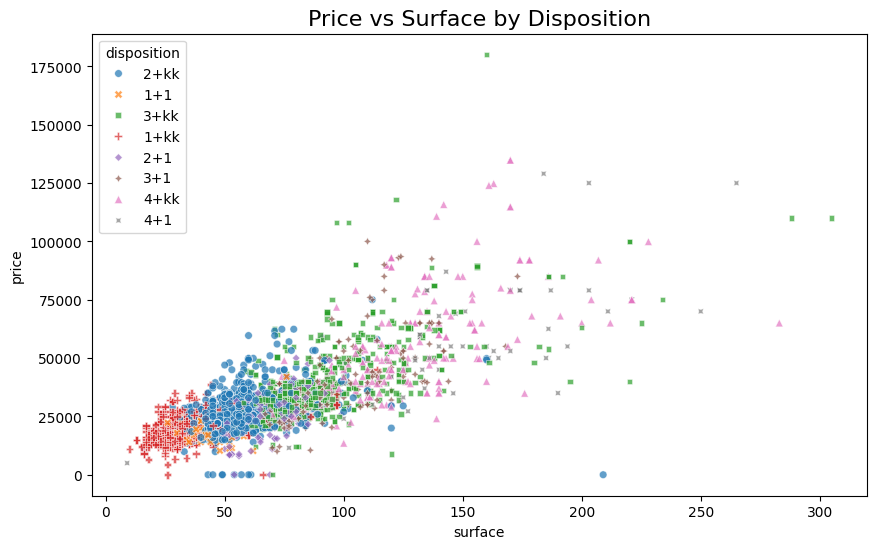

In [39]:
plt.figure(figsize=(10, 6))
palette='tab10'
sns.scatterplot(data=df_rent_filtered, x='surface', y='price', hue='disposition',style='disposition' ,s=30 ,alpha=0.7, palette=palette)
plt.title('Price vs Surface by Disposition', fontsize=16)
plt.show()

# 5 Training model 

In [40]:
def find_missing_percent(df):
    rows =[]
    n= len(df)
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / n) * 100
        rows.append({
            'column': col,
            'missing_count': missing_count,
            'missing_percent': round(missing_percent, 2)
        })
    miss_df = pd.DataFrame(rows)
    return miss_df


In [41]:
miss_df = find_missing_percent(df_rent_filtered)
print(miss_df)

                  column  missing_count  missing_percent
0                  price              0             0.00
1            disposition             76             2.00
2                surface              0             0.00
3                 garage              0             0.00
4             furnishing            961            25.24
5                    mhd              0             0.00
6                balcony              0             0.00
7                 loggia              0             0.00
8               latitude              0             0.00
9              longitude              0             0.00
10              district             76             2.00
11          price_per_m2              0             0.00
12   distance_to_​center              0             0.00
13  distance_to_metro_km              0             0.00
14         nearest_metro              0             0.00


In [42]:
df_rent_filtered=df_rent_filtered.dropna(subset=['disposition', 'district']).reset_index(drop=True)

<Axes: title={'center': 'price'}, xlabel='disposition'>

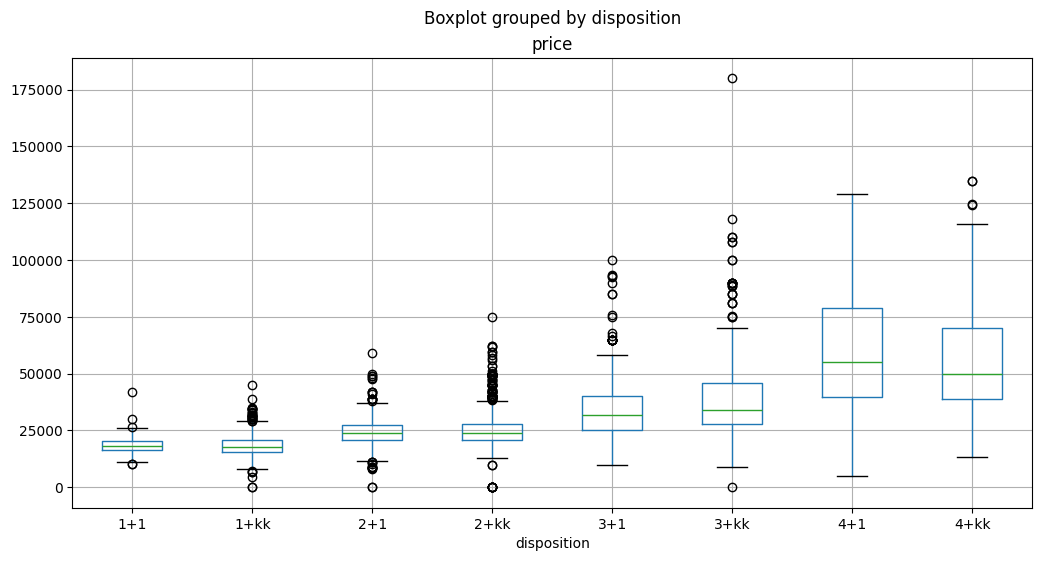

In [43]:
df_rent_filtered['log_price']=np.log(df_rent_filtered['price'])
df_rent_filtered.boxplot(column='price', by='disposition', figsize=(12, 6))

<Axes: title={'center': 'surface'}, xlabel='disposition'>

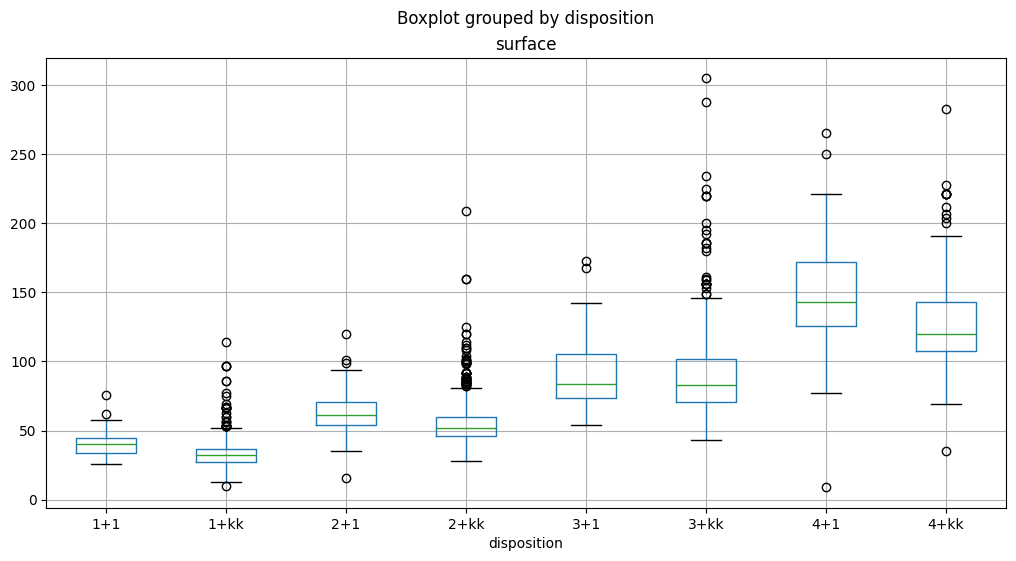

In [44]:
df_rent_filtered.boxplot(column='surface', by='disposition', figsize=(12, 6))

<span style="font-size:17px;">
Lets remove outliers 
</span>

In [45]:
def count_outliers_iqr(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return ((s < lo) | (s > hi)).sum()

outliers_by_disp = (
    df_rent_filtered.groupby("disposition")["surface"]
      .apply(count_outliers_iqr)           
      .rename("outliers")
      .to_frame()
)

outliers_by_disp["n"] = df_rent_filtered.groupby("disposition")["surface"].size()  
outliers_by_disp["share"] = outliers_by_disp["outliers"] / outliers_by_disp["n"]  
print(outliers_by_disp.sort_values("outliers", ascending=False))

             outliers     n     share
disposition                          
2+kk               50  1359  0.036792
1+kk               30   679  0.044183
3+kk               27   673  0.040119
4+kk               12   190  0.063158
2+1                 4   289  0.013841
4+1                 3    75  0.040000
1+1                 2   137  0.014599
3+1                 2   258  0.007752


In [46]:
def delete_outliers(df , column, k=1.5):
    q1 = df.groupby('disposition')[column].transform(lambda s: s.quantile(0.25))
    q3 = df.groupby('disposition')[column].transform(lambda s: s.quantile(0.75))
    iqr = q3-q1
    lo = q1 - k*iqr
    hi = q3 + k*iqr
    return df[(df[column] >= lo) & (df[column] <= hi)].copy()
df_rent_filtered = delete_outliers(df_rent_filtered , 'price' , k=1.5)
df_rent_filtered = delete_outliers(df_rent_filtered , 'surface' , k=1.5)

In [47]:
df_rent_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3355 entries, 0 to 3659
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 3355 non-null   int64  
 1   disposition           3355 non-null   object 
 2   surface               3355 non-null   int64  
 3   garage                3355 non-null   bool   
 4   furnishing            2551 non-null   object 
 5   mhd                   3355 non-null   bool   
 6   balcony               3355 non-null   bool   
 7   loggia                3355 non-null   bool   
 8   latitude              3355 non-null   float64
 9   longitude             3355 non-null   float64
 10  district              3355 non-null   object 
 11  price_per_m2          3355 non-null   float64
 12  distance_to_​center   3355 non-null   float64
 13  distance_to_metro_km  3355 non-null   float64
 14  nearest_metro         3355 non-null   object 
 15  log_price             3355

In [48]:
df_rent_filtered['furnishing'].value_counts()

furnishing
furnished           1100
partly_furnished     947
not_furnished        504
Name: count, dtype: int64

## 5.1 Pipeline

In [49]:
#splitting data into train , test and unknown (to impute furnishing later in pipeline to avoid data leakage)
class Data_splitter:
    def __init__(self ,test_size=0.2,random_state=42):
        self.test_size=test_size
        self.random_state=random_state
    
    def split(self , X , y):
        X = pd.DataFrame(X).copy()
        y = pd.Series(y).copy()

        known_mask = X['furnishing'].notna()
        unknown_mask = X['furnishing'].isna()

        X_known = X.loc[known_mask].copy()
        y_known = y.loc[known_mask].copy()

        X_train_known, X_test_known, y_train_known, y_test_known = train_test_split(
            X_known , y_known , 
            test_size=self.test_size , 
            random_state=self.random_state)
        
        X_unknown = X.loc[unknown_mask].copy()
        y_unknown = y.loc[unknown_mask].copy()
        
        return {
            'train' : (X_train_known , y_train_known),
            'test'  : (X_test_known , y_test_known),
            'unknown' : (X_unknown , y_unknown)
        }

In [50]:
# Custom Encoder class for categorical features
#For disposition and furnishing(we will encode onlly when we will learn model to predict price) using Ordinal encoding 
#For district we will use count encoding(calling during Imputing furnishing) and target encoding for model training

class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self,
                 disposition_encod=False, 
                 furnishing_encod=False,
                 district_mode="none",  # "none", "count", "te"       
                 te_smoothing=20, #smoothing parameter for target encoding to avoid overfitting
                 te_min_samples_leaf=30, #min samples to take category average "safe" , if less model use global mean
                 drop_original_district=True):
        self.disposition_encod = disposition_encod
        self.furnishing_encod  = furnishing_encod
        self.district_mode     = district_mode
        self.te_smoothing      = te_smoothing
        self.te_min_samples_leaf = te_min_samples_leaf
        self.drop_original_district = drop_original_district

        self._disp_map = {"1+kk":1,"1+1":2,"2+kk":3,"2+1":4,"3+kk":5,"3+1":6,
                          "4+kk":7,"4+1":8,"5+kk":9,"5+1":10,"other":11}
        self._furn_map = {"not_furnished":1,
                          "partly_furnished":2,
                          "furnished":3}

        self._count = None      
        self._te    = None      

    def fit(self, X, y=None):
        X = pd.DataFrame(X)

        
        if "district" in X.columns and self.district_mode == "count": 
            self._count = CountEncoder(
                cols=["district"],
                handle_unknown=0, 
                handle_missing=0,
                normalize=True     
            ).fit(X[["district"]])

        if "district" in X.columns and self.district_mode == "te":
            if y is None or not np.issubdtype(pd.Series(y).dtype, np.number):
                raise ValueError("district_mode='te' требует числовой y")
            self._te = TargetEncoder(
                smoothing=self.te_smoothing,
                min_samples_leaf=self.te_min_samples_leaf,
                handle_missing="value",
                handle_unknown="value",
            ).fit(X[["district"]], y)

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        if self.disposition_encod and "disposition" in X.columns:
            X["disposition"] = X["disposition"].map(self._disp_map).fillna(-1).astype(float)

        if self.furnishing_encod and "furnishing" in X.columns:
            X["furnishing"] = X["furnishing"].map(self._furn_map).fillna(-1).astype(float)

        if "district" in X.columns and self._count is not None:
            X["district_count"] = self._count.transform(X[["district"]])["district"]
            if self.drop_original_district:
                X.drop(columns=["district"], inplace=True, errors="ignore")

        if "district" in X.columns and self._te is not None:
            X[["district"]] = self._te.transform(X[["district"]])  

        return X

In [51]:
class FurnishingImputer(BaseEstimator, TransformerMixin):
    def __init__(
    self, 
    feature_cols, #without furnishing
    target_col="furnishing",
    encoder=None, 
    n_estimators=200, # number of trees in ensemble
    max_depth=None,
    random_state=42,
    class_weight="balanced_subsample", # handle class imbalance
    min_samples_split=15,# min samples to split node
    min_samples_leaf=1, # min samples at leaf node
    n_jobs=-1 ):
        self.feature_cols   = list(feature_cols)   
        self.target_col     = target_col
        self.encoder        = encoder
        self.model_ = RandomForestClassifier(n_estimators=n_estimators,
                                             max_depth=max_depth,
                                             random_state=random_state,
                                             class_weight=class_weight,
                                             min_samples_split=min_samples_split,
                                             min_samples_leaf=min_samples_leaf,
                                             n_jobs=n_jobs)
        self.encoder_ = None
        self.feature_cols_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        if self.encoder is not None:
            self.encoder_ = self.encoder
            self.encoder_.fit(X, y)           
            X = self.encoder_.transform(X)

        self.feature_cols_ = [c for c in self.feature_cols if c in X.columns]
        self.model_.fit(X[self.feature_cols_], X[self.target_col])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, copy=True)

        if self.encoder_ is not None:
            X = self.encoder_.transform(X)

    
        X[self.target_col + "_imputed"] = 0
        X.loc[X[self.target_col].isna(), self.target_col + "_imputed"] = 1

    # predict ONLY missing furnishing values
        X.loc[X[self.target_col].isna(), self.target_col] = self.model_.predict(
        X.loc[X[self.target_col].isna(), self.feature_cols_] #можно ли назвать это фин провекркой
    )

        return X

In [52]:
#End-to-end pipeline for rent price prediction with missing data handling
#Pipelines structure:
#-1. Data Splitting (known and unknown furnishing)
#-2. Furnishing Imputation using RandomForestClassifier
#-3. Model Training and Evaluation using multiple regression models with encoding and scaling
class RentPipeline:
    def __init__(self , random_state=42):
        self.random_state = random_state
        self.imputer = None
        self.models = {}
        self.results = {}
        self.data_splits = None
        self.encoder = None
    
    def prepare_data(self , X, y):
        splitter = Data_splitter(test_size=0.2, random_state=self.random_state)
        self.data_splits = splitter.split(X , y)
        
        (X_train_known , y_train_known) = self.data_splits['train']
        (X_test_known , y_test_known) = self.data_splits['test']
        (X_unknown , y_unknown) = self.data_splits['unknown']

        print("Train known size:" , len(X_train_known))
        print("Test known size:" , len(X_test_known))
        print("Unknown size:" , len(X_unknown))
        print("-" * 40)
        return (X_train_known , y_train_known , X_test_known , y_test_known , X_unknown , y_unknown)

    
    def fit_imputer(self , feature_cols , target_col="furnishing"):
        imputer_encoder = Encoder(
            disposition_encod=True,
            furnishing_encod=False,
            district_mode="count"
        ) #Each model gets its own encoder instance to prevent leakage.

        self.imputer = FurnishingImputer(
            feature_cols=feature_cols,
            target_col=target_col,
            encoder=imputer_encoder,
            n_estimators=200,
            max_depth=None,
            random_state=self.random_state,
            class_weight="balanced_subsample",
            min_samples_split=15,
            min_samples_leaf=1,
            n_jobs=-1
        )
        X_train_known , y_train_known = self.data_splits['train']

        if 'furnishing' not in X_train_known.columns:
            raise ValueError("X_train_known must contain 'furnishing' column!")
    
        self.imputer.fit(X_train_known , y_train_known)
        print("Imputer fitted.")

    def evaluate_imputer(self):
        X_test_known, y_test_known = self.data_splits['test']
    
        # Transform training data (encode features)
        X_test_encoded = self.imputer.encoder_.transform(X_test_known.copy())
    
         # Get predictions on training data
        y_pred_train = self.imputer.model_.predict(X_test_encoded[self.imputer.feature_cols_])
    
        # Check if predictions are numeric or already labels
        if isinstance(y_pred_train[0], (int, float)):
            # If numeric, decode them
            reverse_map = {1: "not_furnished", 2: "partly_furnished", 3: "furnished"}
            y_pred_train_labels = [reverse_map[int(p)] for p in y_pred_train]
        else:
        # If already labels, use as is
            y_pred_train_labels = y_pred_train
    
    # Get actual furnishing values
        y_actual = X_test_known['furnishing']
    
        print("=== Imputer Train Metrics ===")
        print(classification_report(y_actual, y_pred_train_labels))
        print("Accuracy:", accuracy_score(y_actual, y_pred_train_labels))

    def create_pipeline(self):
                
        pipelines = {
            "Ridge": Pipeline([
                ("encoder",  Encoder(disposition_encod=True,furnishing_encod=True, district_mode="te")),
                ("scaler", StandardScaler()),
                ("model", Ridge(random_state=self.random_state))
            ]),
            "RandomForestRegressor": Pipeline([
                ("encoder", Encoder(disposition_encod=True,furnishing_encod=True, district_mode="te")),
                ("scaler", StandardScaler()),   
                ("model", RandomForestRegressor(
                    n_estimators=200,
                    max_depth=None,
                    random_state=self.random_state,
                    min_samples_split=15,
                    min_samples_leaf=1,
                    n_jobs=-1))
            ]),
            "Lasso": Pipeline([
                ("encoder", Encoder(disposition_encod=True,furnishing_encod=True, district_mode="te")),
                ("scaler", StandardScaler()),
                ("model", Lasso(random_state=self.random_state))
            ]),
            "ElasticNet": Pipeline([
                ("encoder", Encoder(disposition_encod=True,furnishing_encod=True, district_mode="te")),
                ("scaler", StandardScaler()),
                ("model", ElasticNet(random_state=self.random_state))
            ])
        }

        return pipelines
    
    def train_and_evaluate(self):
        X_train_known , y_train_known = self.data_splits['train']
        X_test_known , y_test_known = self.data_splits['test']

        pipelines = self.create_pipeline()

        for name, pipeline in pipelines.items():
            print("-" * 40)
            print(f"Training {name}...")
            pipeline.fit(X_train_known, y_train_known)
            y_pred = pipeline.predict(X_test_known)

            rmse = mean_squared_error(y_test_known, y_pred, squared=False)
            mae = mean_absolute_error(y_test_known, y_pred)
            r2 = r2_score(y_test_known, y_pred)

            self.models[name] = pipeline
            self.results[name] = {
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2
            }

            print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")
            
                

In [53]:
num_cols   = ["surface", "distance_to_​center","distance_to_metro_km"]
bool_cols  = ["garage", "mhd", "balcony", "loggia"]
ord_cols   = ["disposition", "furnishing"]     
high_cats  = ["district"]                      
feature_cols = num_cols + bool_cols + ord_cols + high_cats

feature_for_imputer = feature_cols.copy()
feature_for_imputer.remove("furnishing")  

pipeline = RentPipeline(random_state=42)
X_train_known , y_train_known , X_test_known , y_test_known , X_unknown , y_unknown = pipeline.prepare_data(
    df_rent_filtered[feature_cols],
    df_rent_filtered["price"]
)

pipeline.fit_imputer(feature_for_imputer , target_col="furnishing")

pipeline.evaluate_imputer()

df_rent_filtered_imputed = pipeline.imputer.transform(df_rent_filtered)

pipeline.train_and_evaluate()

Train known size: 2040
Test known size: 511
Unknown size: 804
----------------------------------------
Imputer fitted.
=== Imputer Train Metrics ===
                  precision    recall  f1-score   support

       furnished       0.57      0.54      0.56       211
   not_furnished       0.34      0.38      0.36       100
partly_furnished       0.55      0.56      0.55       200

        accuracy                           0.51       511
       macro avg       0.49      0.49      0.49       511
    weighted avg       0.52      0.51      0.52       511

Accuracy: 0.5146771037181996
----------------------------------------
Training Ridge...
Ridge - RMSE: 6520.72, MAE: 4321.56, R2: 0.7035
----------------------------------------
Training RandomForestRegressor...
RandomForestRegressor - RMSE: 5380.10, MAE: 3350.46, R2: 0.7982
----------------------------------------
Training Lasso...
Lasso - RMSE: 6521.26, MAE: 4321.65, R2: 0.7035
----------------------------------------
Training ElasticNet

In [54]:
import shap

## The most informative features for our model were …

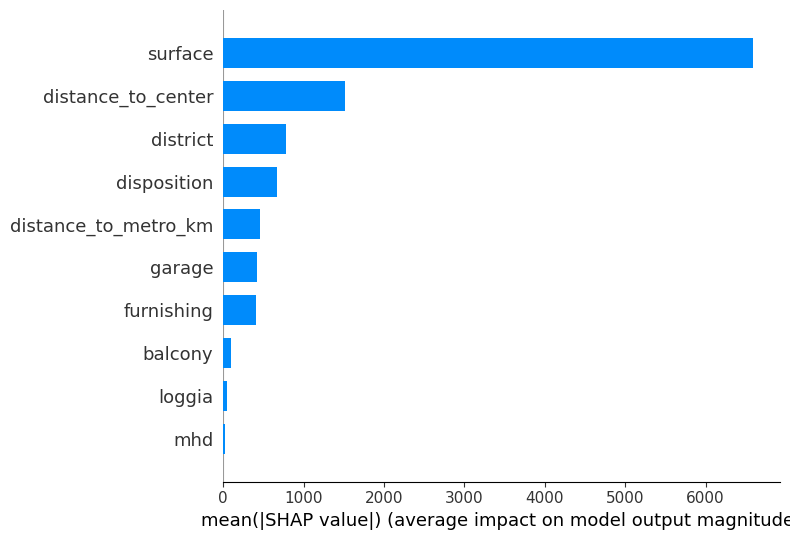

In [55]:
rf_pipe = pipeline.models["RandomForestRegressor"]   

enc    = rf_pipe.named_steps["encoder"]
scaler = rf_pipe.named_steps["scaler"]
rf     = rf_pipe.named_steps["model"]

X_test_enc    = enc.transform(X_test_known.copy())
X_test_scaled = scaler.transform(X_test_enc)

explainer   = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

shap_df = pd.DataFrame(shap_values, columns=X_test_enc.columns)

shap.summary_plot(shap_values, X_test_enc, plot_type="bar")

According to the SHAP analysis, the most informative features for our rental price model are the apartment surface, the distance to the city centre, the district, and the disposition. Surface clearly dominates, meaning that larger flats drive most of the variation in predicted rent. Location-related variables (distance to centre, distance to metro, district) and layout/furnishing play a secondary but still noticeable role, while balcony, loggia, garage and public transport flags have only a minor impact.

In [56]:
df_sell_filtered

,price,disposition,surface,garage,furnishing,mhd,balcony,loggia,latitude,longitude,district,price_per_m2,distance_to_​center,distance_to_metro_km,nearest_metro
0,8782000,2+1,91,False,NaN,True,False,False,50.055476,14.539382,Hostivař,96505.5,9.5,2.7,Skalka
1,7990000,4+kk,137,False,furnished,False,False,False,50.103169,14.474951,Libeň,58321.2,4.5,0.1,Palmovka
2,9190000,1+kk,56,True,partly_furnished,True,False,True,50.028470,14.360102,Hlubočepy,164107.1,7.7,2.6,Nové Butovice
3,12990000,3+kk,70,True,furnished,False,False,False,50.140531,14.448247,Dolní Chabry,185571.4,6.3,1.9,Kobylisy
4,10250000,3+kk,80,True,partly_furnished,False,False,True,50.115259,14.565936,Kyje,128125.0,11.1,1.1,Rajská zahrada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,9990000,3+1,73,False,None,True,True,False,50.025204,14.440320,Braník,136849.3,7.2,2.3,Budějovická
2299,4999000,1+kk,32,False,partly_furnished,True,False,False,50.139656,14.548674,Kbely,156218.8,11.1,2.8,Letňany
2300,16000000,3+1,130,False,None,True,False,False,50.064800,14.320167,Stodůlky,123076.9,7.3,1.9,Nemocnice Motol
2301,1,2+kk,44,False,None,True,False,False,50.084553,14.417781,Staré Město,0.0,0.4,0.5,Můstek


In [57]:
sell_clean =df_sell_filtered.dropna(subset= feature_cols).copy()
sell_clean['rent_month_pred'] = rf_pipe.predict(sell_clean[feature_cols])
sell_clean['rent_month_pred']=round(sell_clean['rent_month_pred'],0)

In [58]:
sell_clean['rent_year_income'] = round(sell_clean['rent_month_pred'] * 12 , 2)
sell_clean['payback_years'] = round(sell_clean['price']/sell_clean['rent_year_income'], 2)

(0.0, 100.0)

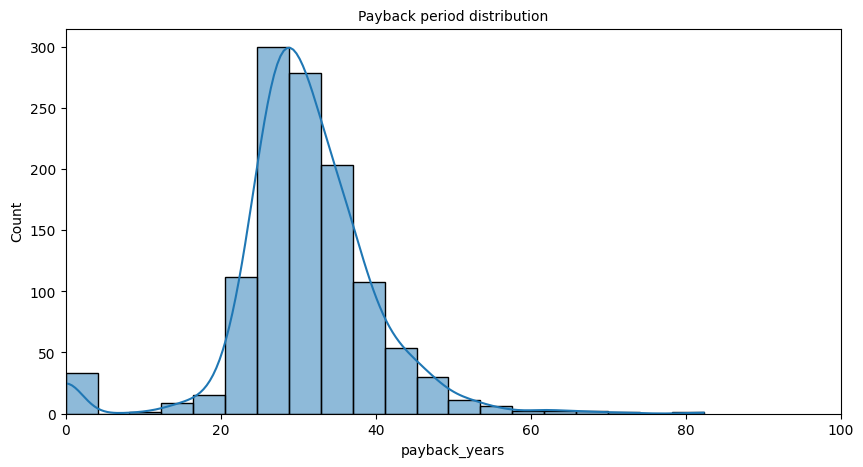

In [78]:
plt.figure(figsize=(10, 5))
sns.histplot(data=sell_clean, x='payback_years', bins=20, kde=True)
plt.title('Payback period distribution', fontsize=10)
plt.xlim(0, 100)

In [94]:
top_districts_sell = sell_clean['district'].value_counts().head(10).index
df_sell_top_districts = sell_clean[sell_clean['district'].isin(top_districts_sell)]

In [ ]:
agg_numeric_sell = (
    df_sell_top_districts
    .groupby('district')
    .agg(
        price_mean=('price', 'mean'),
        payback_years_mean=('payback_years', 'mean'),
        count=('price', 'count')          
    )
)

agg_numeric_sell['price_mean'] = agg_numeric_sell['price_mean'].round(0)
agg_numeric_sell['payback_years_mean'] = agg_numeric_sell['payback_years_mean'].round(2)

agg_numeric_sell = agg_numeric_sell.sort_values(by='count', ascending=False)

agg_disposition_sell = df_sell_top_districts.pivot_table(
    index='district',
    columns='disposition',
    aggfunc='size',
    fill_value=0
)

df_sell_final = pd.concat([agg_numeric_sell, agg_disposition_sell], axis=1)

df_sell_final.head(10)

,price_mean,payback_years_mean,count,1+1,1+kk,2+1,2+kk,3+1,3+kk,4+1,4+kk
district,,,,,,,,,,,
Smíchov,12365113.0,29.68,78,7,4,5,21,7,23,3,8
Žižkov,10773336.0,32.44,66,5,8,5,27,3,14,0,4
Nové Město,14012662.0,30.31,60,3,8,5,14,3,15,7,5
Libeň,10513031.0,30.46,59,3,12,3,19,1,12,0,9
Vinohrady,15472640.0,32.74,48,0,4,1,21,8,5,2,7
Hlubočepy,9588000.0,32.09,39,0,7,4,15,2,8,1,2
Nusle,10147182.0,28.58,39,3,7,1,8,1,13,4,2
Stodůlky,10912924.0,27.53,39,0,6,0,9,9,8,3,4
Holešovice,14319595.0,35.52,36,2,4,2,9,6,6,5,2


In [102]:
df_sell_agg = sell_clean.groupby('disposition')[['payback_years' , 'rent_year_income']].mean().round(2).reset_index()
df_sell_agg.head(10)

,disposition,payback_years,rent_year_income
0,1+1,26.67,246869.49
1,1+kk,27.88,221918.54
2,2+1,27.47,291191.17
3,2+kk,32.02,302042.73
4,3+1,27.20,397652.34
5,3+kk,33.08,402016.22
6,4+1,29.84,593151.64
7,4+kk,34.38,574424.11


In [66]:
excellent = (sell_clean['payback_years'] < 20).sum()
good = ((sell_clean['payback_years'] >= 20) & (sell_clean['payback_years'] < 25)).sum()
moderate = ((sell_clean['payback_years'] >= 25) & (sell_clean['payback_years'] < 30)).sum()
poor = (sell_clean['payback_years'] >= 30).sum()

print(f"🟢 Excellent (< 20 years):  {excellent:4d} properties ({excellent/len(sell_clean)*100:5.1f}%)")
print(f"🟡 Good (20-25 years):      {good:4d} properties ({good/len(sell_clean)*100:5.1f}%)")
print(f"🟠 Moderate (25-30 years):  {moderate:4d} properties ({moderate/len(sell_clean)*100:5.1f}%)")
print(f"🔴 Poor (≥ 30 years):       {poor:4d} properties ({poor/len(sell_clean)*100:5.1f}%)")

🟢 Excellent (< 20 years):    56 properties (  4.8%)
🟡 Good (20-25 years):       126 properties ( 10.8%)
🟠 Moderate (25-30 years):   374 properties ( 32.0%)
🔴 Poor (≥ 30 years):        613 properties ( 52.4%)
